In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm


from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Lambda, LSTM,  Bidirectional, Conv1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import RandomNormal, glorot_uniform

# Load Bitcoin price data

In [2]:
df = pd.read_csv("hourly_data_2024_08_02.csv", parse_dates =['time'])
df.set_index('time', inplace= True) # set `time` as index of dataframe
df = df[~df.index.duplicated(keep='first')] # drop duplicated indices
df = df[(df.index >= "2018-01-01") & (df.index <= "2024-07-30")] # To see why we drop old data, see Analysis_Statistcal_Models notebook

df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2018-01-01 00:00:00,13857.01,13598.91,13850.49,3936.05,5.414317e+07,13642.93,direct,NaN
2018-01-01 01:00:00,13690.14,13330.07,13642.93,3900.16,5.302141e+07,13352.04,direct,NaN
2018-01-01 02:00:00,13488.90,13318.52,13352.04,3028.41,4.079472e+07,13408.70,direct,NaN
2018-01-01 03:00:00,13647.63,13383.99,13408.70,3246.38,4.416929e+07,13458.77,direct,NaN
2018-01-01 04:00:00,13633.43,13364.42,13458.77,2931.72,3.982689e+07,13631.46,direct,NaN
...,...,...,...,...,...,...,...,...
2024-07-29 20:00:00,67391.82,67157.24,67300.34,694.72,4.673480e+07,67372.45,direct,NaN
2024-07-29 21:00:00,67504.08,67022.86,67372.45,695.05,4.673790e+07,67489.04,direct,NaN
2024-07-29 22:00:00,67545.84,67142.90,67489.04,566.95,3.818581e+07,67228.03,direct,NaN


# Calculate every 4 hours weekly ROI 

In the Analysis_Statistical_Models notebook, we discussed the reasoning behind using the weekly ROI for every day of the week and every 4 and 8 hours. In this notebook, we will use every 4 hours weekly ROI.

In [3]:
# This function calculates the weekly ROI based on the given day of the week and time.

def roi_df(dataframe, day, hour):
    df_out = pd.DataFrame()

    df_out["Day_Hour_Close"] = dataframe[(dataframe.index.hour == hour) &(dataframe.index.weekday == day)]["close"] 
    df_out["Next_Day_Hour_Close"] = df_out["Day_Hour_Close"].shift(-1)
    df_out.dropna(inplace = True)
    df_out["7_Day_ROI"]= (df_out['Next_Day_Hour_Close'] - df_out['Day_Hour_Close']) / df_out['Day_Hour_Close'] * 100
    df_out.drop(columns = ["Day_Hour_Close", "Next_Day_Hour_Close"], inplace = True)

    return df_out

In [4]:
desired_hours = [0, 4, 8, 12, 16, 20]
df_4h= df[["close"]]
df_4h = df_4h[df_4h.index.hour.isin(desired_hours)]
df_4h

,close
time,
2018-01-01 00:00:00,13642.93
2018-01-01 04:00:00,13631.46
2018-01-01 08:00:00,13493.98
2018-01-01 12:00:00,13229.17
2018-01-01 16:00:00,13078.93
...,...
2024-07-29 08:00:00,69463.36
2024-07-29 12:00:00,69803.41
2024-07-29 16:00:00,66929.11


In [5]:
df_roi_4h= roi_df(df_4h, day=0, hour = 0)
df_roi4= roi_df(df_4h, day=0, hour = 4)
df_roi8= roi_df(df_4h, day=0, hour = 8)
df_roi12 = roi_df(df_4h, day =0, hour =12)
df_roi16= roi_df(df_4h, day=0, hour = 16)
df_roi20 = roi_df(df_4h, day =0, hour =20)

df_roi_4h = pd.concat([df_roi_4h, df_roi4, df_roi8,df_roi12,df_roi16,df_roi20])

for d in range(1,8):
    for i in range(6):
        df_roi_new = roi_df(df_4h, day=d, hour = i*4)
        df_roi_4h = pd.concat([df_roi_4h, df_roi_new])
    


df_roi_4h = df_roi_4h.sort_index()#(by='time').reset_index(drop=True)

df_roi_4h.index.name = "time"
df_roi_4h

C:\Users\solmaz\AppData\Local\Temp\ipykernel_9524\1965999494.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_roi_4h = pd.concat([df_roi_4h, df_roi_new])
C:\Users\solmaz\AppData\Local\Temp\ipykernel_9524\1965999494.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_roi_4h = pd.concat([df_roi_4h, df_roi_new])
C:\Users\solmaz\AppData\Local\Temp\ipykernel_9524\1965999494.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the res

,7_Day_ROI
time,
2018-01-01 00:00:00,17.248128
2018-01-01 04:00:00,15.253098
2018-01-01 08:00:00,14.969268
2018-01-01 12:00:00,16.635586
2018-01-01 16:00:00,13.787213
...,...
2024-07-22 08:00:00,3.530154
2024-07-22 12:00:00,3.088608
2024-07-22 16:00:00,-0.205243


# Naive Model

Before we proceed to advanced methods, let's look at the prediction from a naive model, which assigns the value of the last time slot to the current time slot as the prediction. This will serve as our baseline accuracy.

In [9]:
split = pd.to_datetime("2023-12-31 20:00:00")
train = df_roi_4h.loc[: split]
test  = df_roi_4h.loc[split + timedelta(hours=4):]

print("Number of data in train:", len(train))
print("Number of data in train:", len(test))


df_naive_4h  = df_roi_4h["7_Day_ROI"].shift(-1)
prediction_naive = df_naive_4h[split + timedelta(hours=4):]
prediction_naive[-1] = prediction_naive[-2]
prediction_naive

Number of data in train: 13146
Number of data in train: 1225


C:\Users\solmaz\AppData\Local\Temp\ipykernel_9524\1557535773.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediction_naive[-1] = prediction_naive[-2]
C:\Users\solmaz\AppData\Local\Temp\ipykernel_9524\1557535773.py:11: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  prediction_naive[-1] = prediction_naive[-2]


time
2024-01-01 00:00:00    2.897226
2024-01-01 04:00:00    3.153144
2024-01-01 08:00:00    5.860147
2024-01-01 12:00:00    5.258551
2024-01-01 16:00:00    7.128274
                         ...   
2024-07-22 08:00:00    3.088608
2024-07-22 12:00:00   -0.205243
2024-07-22 16:00:00   -1.128811
2024-07-22 20:00:00   -1.367902
2024-07-23 00:00:00   -1.367902
Name: 7_Day_ROI, Length: 1225, dtype: float64

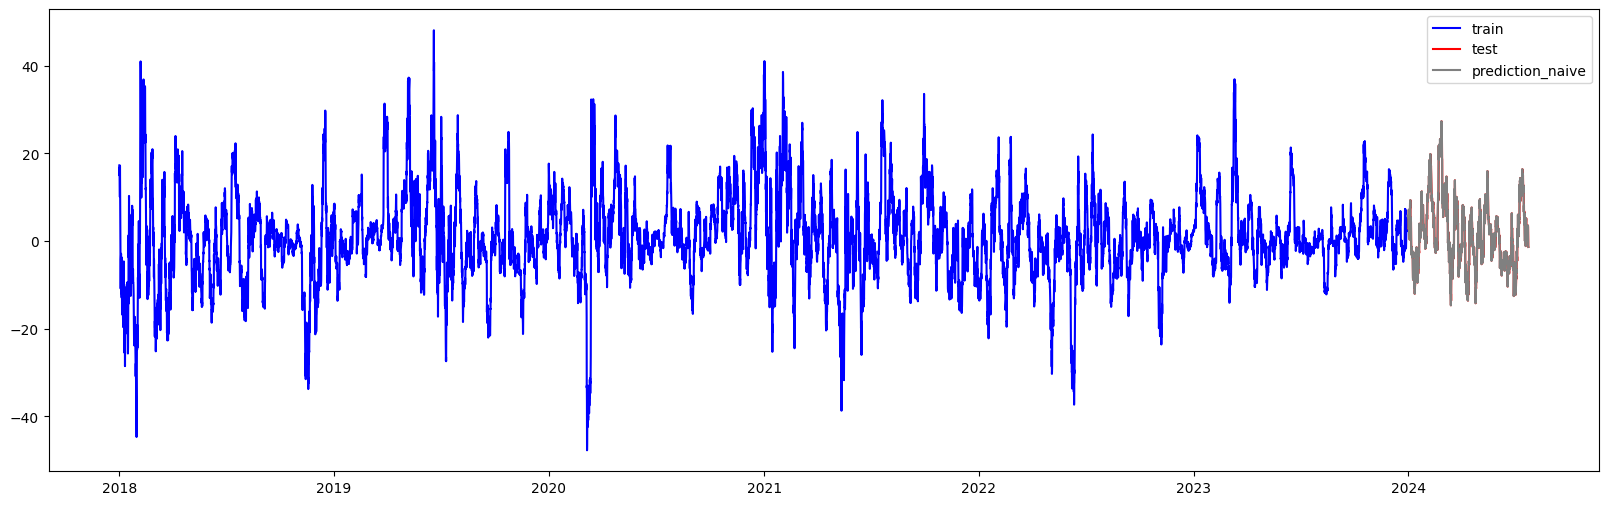

In [10]:
plt.figure(figsize = (20,6))
plt.plot(train, color = "blue", label = "train")
plt.plot(test, color = "red", label = "test")
plt.plot(prediction_naive, color = "gray", label = "prediction_naive")
plt.legend()

In [11]:
mae = mean_absolute_error(test, prediction_naive)
print("Mean absolute Error: ", mae)

mse = mean_squared_error(test, prediction_naive)
print("Mean Square Error: ", mse)

Mean absolute Error:  1.130516249389173
Mean Square Error:  2.652758560940488


# Data Preprocessing

We are going to use sequential models (like RNN, LSTM) and need to prepare the data in a way that it can be fed into these models. Sequential models require the input to be structured as sequences with a length equals to the given `window_size`. The following chunk of code defines a `preprocessing` function that transforms the input data into sequences and prepares it for training:


1. Convert data to a TensorFlow dataset: The input data is converted into a TensorFlow dataset format which prepares the data for further transformations.

2. Create sliding windows: Sliding windows are created over the dataset, with each window containing a specified number of elements `window_size`. The window moves by a specified number of elements `shift`. We set `remainder =True` to exclude the windows wich have less elements

3. Convert windows into batches: Since each window has dataset type, we have to change their type to tensor using `flat_map` mathod.

4. Split windows into features and labels: The data in each window is split into two parts: features and labels. The features are all elements except the last one, while the label is the last element. This prepares the input-output pairs needed for training the model.

5. Shuffle the dataset: The dataset is shuffled to avoid model overfitting and ensure better training performance. Shuffling introduces randomness into the order of the data, which helps the model generalize better.

6. Batch and prefetch the data: The dataset is divided into batches of a specified size, which will be fed into the model during training. Prefetching is used to optimize performance by loading data in advance, reducing waiting times during model execution.


In [12]:
def preprocessing(data, window_size, batch_size, shuffle_buffer_size, shift=1 ):
    
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(size=window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    feature_label = dataset.map(lambda window: (window[:-1], window[-1]))
    feature_label = feature_label.shuffle(buffer_size=shuffle_buffer_size)
    feature_label = feature_label.batch(batch_size).prefetch(1)
    return feature_label

We will also use the following function whenever we want to check the performance of the model and visualize the model's results. The following `make_prediction` function helps us generate forecasts using a trained model and compare them with actual data.

In [13]:
def make_prediction(dataframe, model, time_feature, feature_name , window_size, split_index, verbose, test = True):
    '''
    dataframe must be the Pandas series or numpy array of the whole(train and test) variable
    split_index = len(train)
    '''
    if isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe.reset_index(inplace=True)
    
    forecast = []
    if test:
        start_index = split_index-window_size+1
        no_windows = len(dataframe)-start_index-window_size+1
        time = dataframe[time_feature][split_index: ]
        #print(start_index)
        #print(no_windows)
    else:
        start_index = 0
        no_windows = split_index-window_size+1
        time = dataframe[time_feature][window_size-1:split_index]

    if len(time) == no_windows:
        for i in range(start_index, start_index+no_windows):
            forecast.append(model.predict(dataframe[feature_name][i:window_size-1+i].values[np.newaxis], verbose = verbose))

    else:
        raise Exception("Not equal number of time stamps and number of windows")
    

    return time, np.array(forecast).squeeze()

To visualize the accuracy and loss of during training process, we will use the following function:

In [14]:
def learning_curve(history, metrics , zoom_in_epoch, metrics_max, val= True):
    epochs = len(history.history[metrics[0]])
    metric0_values_train = history.history[metrics[0]][zoom_in_epoch:]
    metric1_values_train = history.history[metrics[1]][zoom_in_epoch:]
    if val:
        metric0_values_val = history.history["val_"+metrics[0]][zoom_in_epoch:]
        metric1_values_val = history.history["val_"+metrics[1]][zoom_in_epoch:]
    
    epoch_range = range(zoom_in_epoch, zoom_in_epoch+ len(metric1_values_train))

    fig, ax = plt.subplots(1,2, figsize= (15,5))
    ax[0].set_title(f"{metrics[0]} learning curve")
    ax[0].plot(epoch_range, metric0_values_train, label = f"Training", color = "b")
    if val:
        ax[0].plot(epoch_range, metric0_values_val, label = f"Validation", color = "r")
    ax[0].axis([zoom_in_epoch, epochs, 0, metrics_max[0] ])
    ax[0].legend()

    ax[1].set_title(f"{metrics[1]} learning curve")
    ax[1].plot(epoch_range, metric1_values_train, label = f"Training", color = "b")
    if val:
        ax[1].plot(epoch_range, metric1_values_val, label = f"Validation", color = "r")
    ax[1].axis([zoom_in_epoch, epochs, 0, metrics_max[1] ])
    ax[1].legend()

# Model Training

In [15]:
# Train Test split
split = pd.to_datetime("2023-12-31 20:00:00")
split_index = df_roi_4h.index.get_loc(split)
train = df_roi_4h.loc[: split]
test  = df_roi_4h.loc[split + timedelta(hours = 4):]
split_index = len(train)
exact_test  = test[(test.index.hour == 20) &(test.index.weekday == 0)]

In [16]:
## Set values for the training variables
verbose = 0
window_size = 14
batch_size = 512
#epochs_train = 25

In [17]:
## Create train and test sequetial data

feature_label_train = preprocessing(train["7_Day_ROI"], window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

feature_label_test = preprocessing(test["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

To provide more insight into the output of `preprocess` function, let's print elements of a single batch is `feature_label_train`:

In [18]:
for windows in feature_label_train.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  x,y = windows
  print("x = ", x.numpy())
  print("Shape of x:", x.shape)
  print("y = ", y.numpy())
  print("Shape of y:", y.shape)
  print()

data type: <class 'tuple'>
number of elements in the tuple: 2
x =  [[19.58623794 21.27264717 28.76414858 ... 24.59318313 25.23996886
  30.19498239]
 [14.53751197  4.94064974  5.49306119 ... -1.84934377 -2.86540905
  -3.01864909]
 [-1.46178563 -1.38082025  1.17580844 ...  3.17421366  3.88511854
   4.47293267]
 ...
 [-8.0879372  -7.54663474 -6.32646155 ... -4.70452955 -4.94116362
  -5.81587701]
 [-1.06453684 -1.46178563 -1.38082025 ...  4.72174944  3.17421366
   3.88511854]
 [-0.42969721  1.57681497 -0.27524308 ... -7.95203743 -9.39003841
  -9.65814695]]
Shape of x: (512, 13)
y =  [ 3.13623180e+01 -3.99232178e+00  4.40333153e+00  1.70177085e+00
  1.55453057e+01  2.69177163e+01  7.26051494e+00  1.25994063e+01
  5.36435229e+00 -8.07932144e-01  3.43278006e+00  2.31085690e+01
 -1.31313751e+01 -2.48985861e+00  5.60040064e+00 -1.02223098e+01
 -1.94367735e+01 -1.52696809e+00  9.62506263e-02 -5.57542364e+00
  3.54385340e+00 -1.19201529e+01 -2.13746936e+01  2.94267584e+00
  2.78945437e+01 -5.9000

## One layer network: Linear Regression

In [30]:
# Build the single layer neural network with one unit and identity activation function
l0 = Dense(1, input_shape=[window_size-1])
lr = Sequential([l0])

lr.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
lr.compile(loss="mae", metrics = ['mae'], optimizer=SGD(learning_rate=1e-4, momentum=0.9))
history = lr.fit(feature_label_train, epochs=150, validation_data= feature_label_test)

Epoch 1/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3889 - mae: 1.3889 - val_loss: 1.1279 - val_mae: 1.1279
Epoch 2/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3919 - mae: 1.3919 - val_loss: 1.1279 - val_mae: 1.1279
Epoch 3/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3822 - mae: 1.3822 - val_loss: 1.1280 - val_mae: 1.1280
Epoch 4/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3791 - mae: 1.3791 - val_loss: 1.1283 - val_mae: 1.1283
Epoch 5/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3760 - mae: 1.3760 - val_loss: 1.1277 - val_mae: 1.1277
Epoch 6/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3958 - mae: 1.3958 - val_loss: 1.1291 - val_mae: 1.1291
Epoch 7/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3847 - mae: 1.3847 - val_loss: 1.1302 - val_mae: 1.1302
Epoch 8/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3792 - mae: 1.3792 - val_loss: 1.1279 - val_mae: 1.1279
Epoch 9/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.359

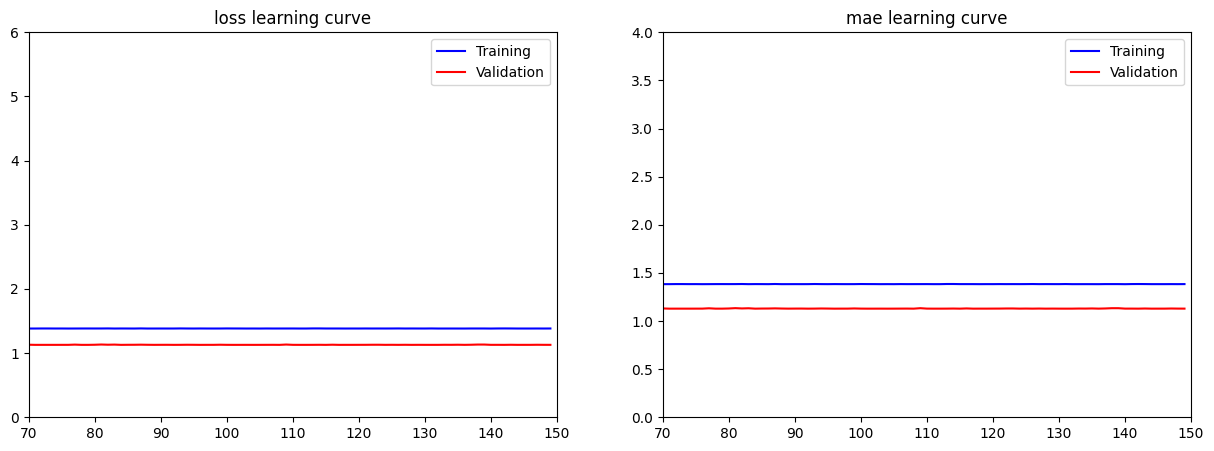

In [33]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch= 70, metrics_max = [6, 4], val= True)

In [34]:
#time_train, forecast_train_lr = make_prediction(df_roi_4h, model = lr, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = False)
time_test, forecast_test_lr = make_prediction(df_roi_4h, model = lr, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True)

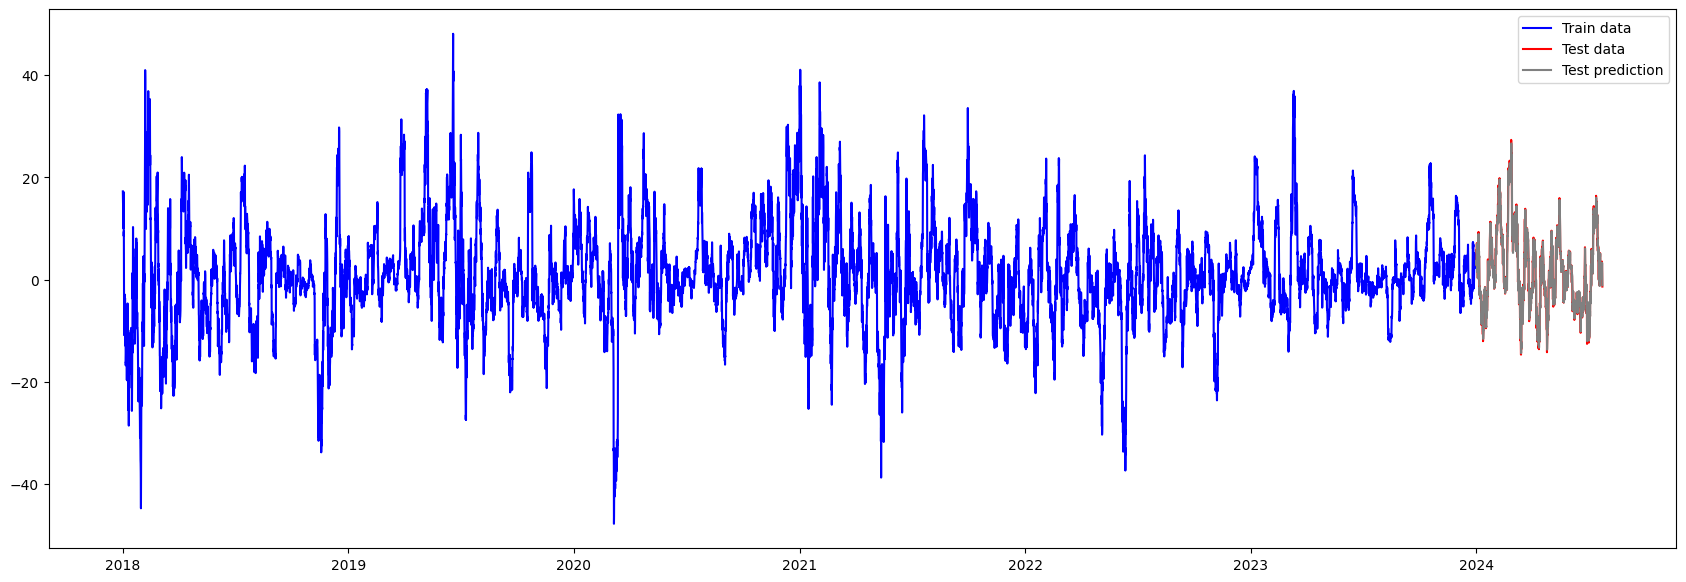

In [35]:
plt.figure(figsize = (21,7))
plt.plot(train, color = 'blue', label = "Train data")
#plt.plot(time_train, forecast_train_lr, color = "gray", label = "Train prediction")
plt.plot(test, color = 'red', label = "Test data")
plt.plot(time_test, forecast_test_lr, color = "gray", label = "Test prediction")

plt.legend()

In [36]:
mae = mean_absolute_error(test.values, forecast_test_lr)
print("Mean absolute Error: ", mae)

mse = mean_squared_error(test.values, forecast_test_lr)
print("Mean Square Error: ", mse)

Mean absolute Error:  1.1312396758863157
Mean Square Error:  2.6440302053172253


## Three layers NNs

In [37]:
model_3dnn = Sequential()
model_3dnn.add(Dense(20, activation = 'relu', input_shape = [window_size-1]))
model_3dnn.add(Dense(20, activation = 'relu'))
model_3dnn.add(Dense(1))


model_3dnn.compile(loss = 'mse', metrics = ["mae"], optimizer = SGD(learning_rate=1e-4, momentum =0.9))

history = model_3dnn.fit(feature_label_train, epochs=100, validation_data= feature_label_test)

Epoch 1/100


c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 42.7683 - mae: 4.3829 - val_loss: 5.6641 - val_mae: 1.7698
Epoch 2/100


c:\Users\solmaz\anaconda3\envs\TR\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8134 - mae: 2.0455 - val_loss: 4.1640 - val_mae: 1.5149
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8136 - mae: 1.8034 - val_loss: 3.7758 - val_mae: 1.4221
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2194 - mae: 1.7067 - val_loss: 3.5876 - val_mae: 1.3834
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7886 - mae: 1.6431 - val_loss: 3.4972 - val_mae: 1.3608
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7500 - mae: 1.6364 - val_loss: 3.4177 - val_mae: 1.3456
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5186 - mae: 1.6111 - val_loss: 3.3986 - val_mae: 1.3365
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4922 - mae: 1.5997 - val_loss: 3.3292 - val_mae: 1.3164
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6367 - mae: 1.6006 - val_loss: 3.2978 - val_mae: 1.3172
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4041 - mae: 1.

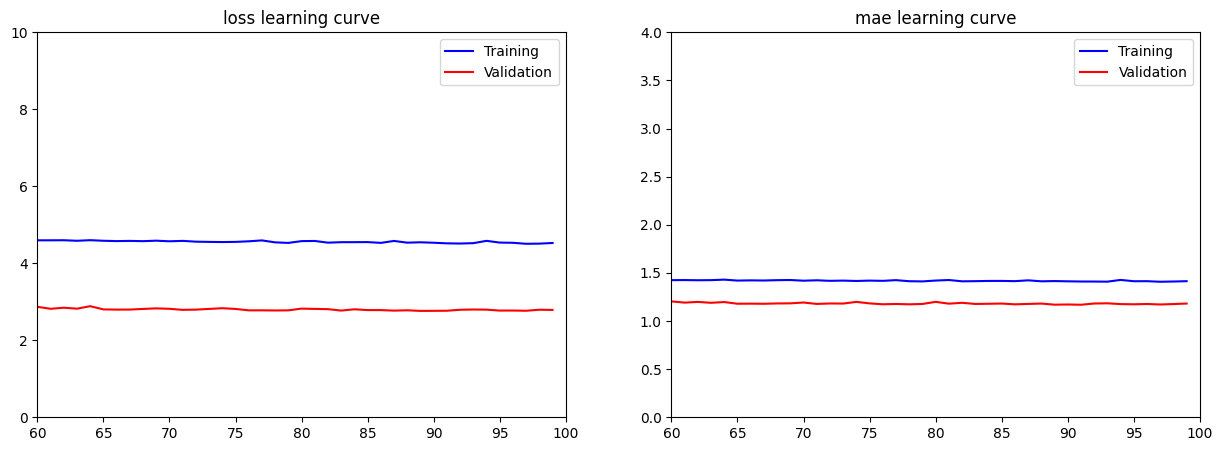

In [38]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch= 60, metrics_max = [10, 4], val= True)

In [39]:
#time_train, forecast_train_3dnn = make_prediction(df_roi_4h, model = model_3dnn, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = False)
time_test, forecast_test_3dnn = make_prediction(df_roi_4h, model = model_3dnn, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True)

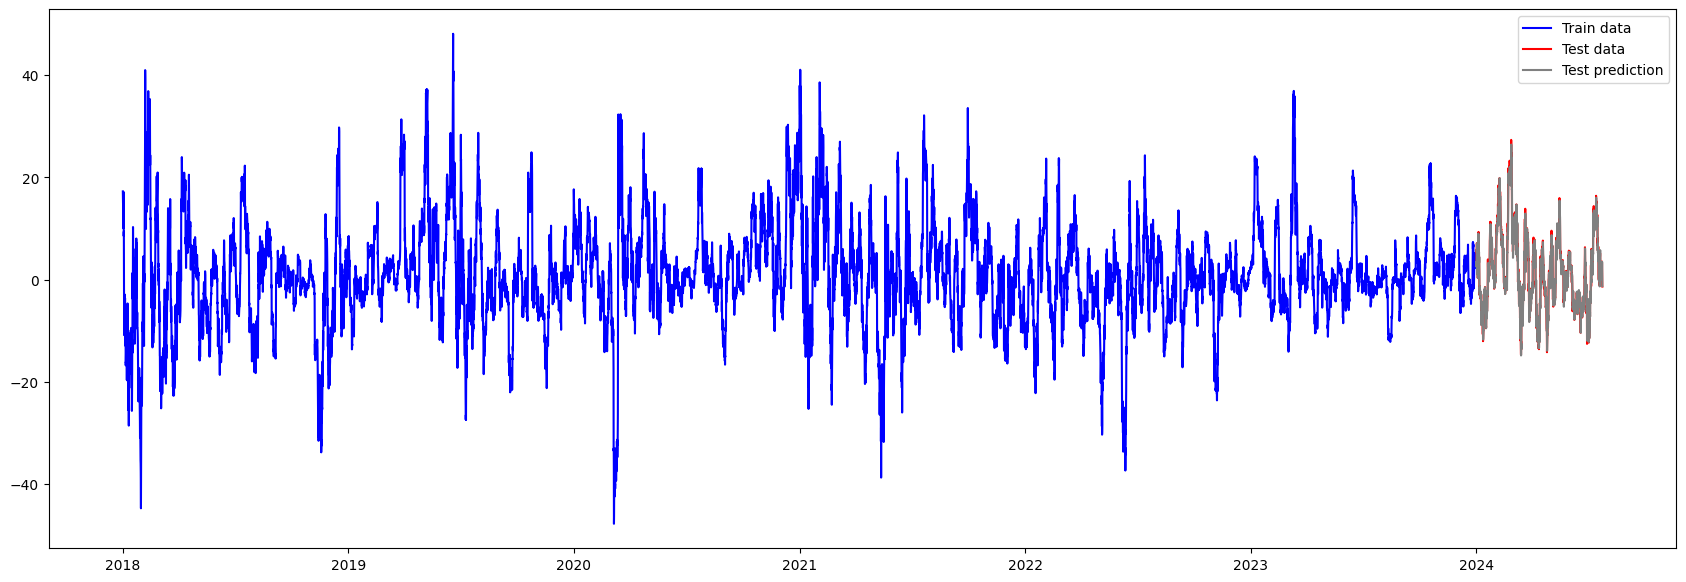

In [40]:
plt.figure(figsize = (21,7))
plt.plot(train, color = 'blue', label = "Train data")
#plt.plot(time_train, forecast_train_3dnn, color = "gray", label = "Train prediction")
plt.plot(test, color = 'red', label = "Test data")
plt.plot(time_test, forecast_test_3dnn, color = "gray", label = "Test prediction")

plt.legend()

In [41]:
mae = mean_absolute_error(test.values, forecast_test_3dnn)
print("Mean absolute Error: ", mae)

mse = mean_squared_error(test.values, forecast_test_3dnn)
print("Mean Square Error: ", mse)

Mean absolute Error:  1.1842398778665302
Mean Square Error:  2.792539648979126


It seems the performance of the 3-layer neural network is better than that of the 1-layer model on this data. Let's proceed with more advanced models.

## SimpleRNN

### Try 1

In [45]:
# Build the Model
model_rnn = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  SimpleRNN(50),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range

])

model_rnn.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_rnn.fit(feature_label_train, epochs = 60, validation_data= feature_label_test )

Epoch 1/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 82.2799 - mae: 6.7029 - val_loss: 19.9576 - val_mae: 3.4794
Epoch 2/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 50.3558 - mae: 4.6155 - val_loss: 18.8431 - val_mae: 3.3414
Epoch 3/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 46.8425 - mae: 4.3775 - val_loss: 17.5944 - val_mae: 3.1065
Epoch 4/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 46.9552 - mae: 4.2298 - val_loss: 17.2311 - val_mae: 3.0330
Epoch 5/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 44.9715 - mae: 4.1084 - val_loss: 16.9729 - val_mae: 2.9759
Epoch 6/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 45.0581 - mae: 4.0781 - val_loss: 16.8378 - val_mae: 2.9440
Epoch 7/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 44.3999 - mae: 4.0661 - val_loss: 16.7643 - val_mae: 2.9235
Epoch 8/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 45.6004 - mae: 4.0506 - val_loss: 16.7046 - val_mae: 2.9101
Epoch 9/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - los

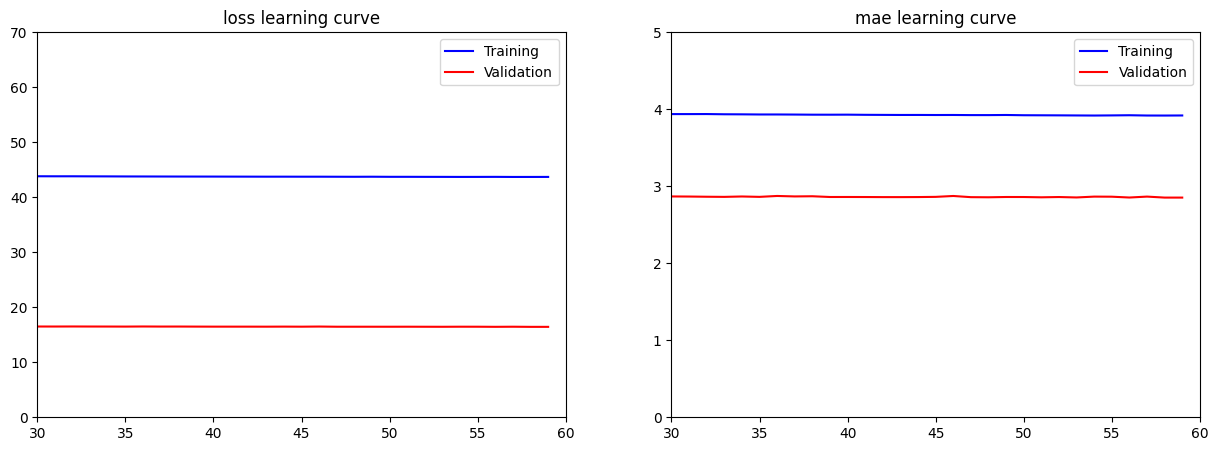

In [46]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch=30, metrics_max = [70, 5], val= True)

In [47]:
#time_train, forecast_train_rnn = make_prediction(df_roi_4h, model = model_3dnn, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = False)
time_test, forecast_test_rnn = make_prediction(df_roi_4h, model = model_rnn, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True)

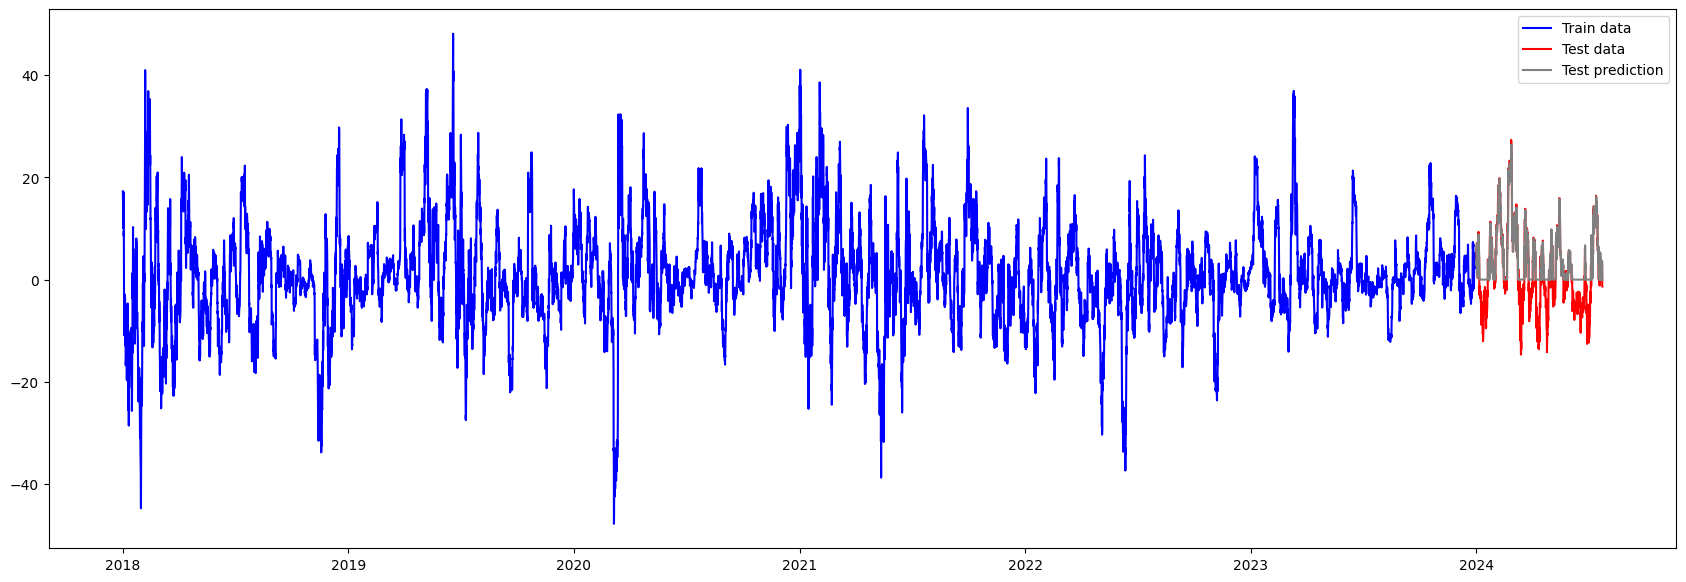

In [48]:
plt.figure(figsize = (21,7))
plt.plot(train, color = 'blue', label = "Train data")
#plt.plot(time_train, forecast_train_rnn, color = "gray", label = "Train prediction")
plt.plot(test, color = 'red', label = "Test data")
plt.plot(time_test, forecast_test_rnn, color = "gray", label = "Test prediction")

plt.legend()

In [49]:
mae = mean_absolute_error(test.values, forecast_test_rnn)
print("Mean absolute Error: ", mae)

mse = mean_squared_error(test.values, forecast_test_rnn)
print("Mean Square Error: ", mse)

Mean absolute Error:  2.837283009194435
Mean Square Error:  16.298745503896832


The performance of this RNN network is not as good as the 3-layer neural network. Let's try a different architecture:

### Try 2

In [50]:
# Build the Model
model_rnn = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  SimpleRNN(60, return_sequences= True),
  SimpleRNN(30),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range

])

model_rnn.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_rnn.fit(feature_label_train, epochs = 80, validation_data= feature_label_test )

Epoch 1/80


c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     20/Unknown 2s 6ms/step - loss: 83.0058 - mae: 6.5348

c:\Users\solmaz\anaconda3\envs\TR\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 78.2769 - mae: 6.3042 - val_loss: 19.2927 - val_mae: 3.4150
Epoch 2/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 46.2772 - mae: 4.3345 - val_loss: 17.2024 - val_mae: 3.0190
Epoch 3/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 44.4005 - mae: 4.1104 - val_loss: 16.9478 - val_mae: 2.9659
Epoch 4/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 45.0756 - mae: 4.0725 - val_loss: 16.8661 - val_mae: 2.9504
Epoch 5/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 45.2516 - mae: 4.0686 - val_loss: 16.8579 - val_mae: 2.9545
Epoch 6/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 43.7539 - mae: 4.0426 - val_loss: 16.8212 - val_mae: 2.9443
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 44.2653 - mae: 4.0536 - val_loss: 16.8322 - val_mae: 2.9394
Epoch 8/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 44.4774 - mae: 4.0107 - val_loss: 16.7851 - val_mae: 2.9312
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 44.7507 

Adding an additional RNN layer did not improve the model's performance. Let's add a Dense layer.

### Try 3

In [52]:
# Build the Model
model_rnn = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  SimpleRNN(50),
  Dense(50, activation = 'relu'),
  #Dense(40, activation = 'relu'),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range

])

model_rnn.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_rnn.fit(feature_label_train, epochs = 50, validation_data= feature_label_test )

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 146.6395 - mae: 8.7604 - val_loss: 58.7819 - val_mae: 6.0465
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 97.3343 - mae: 7.0599 - val_loss: 58.6980 - val_mae: 6.0318
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 98.8356 - mae: 7.0491 - val_loss: 58.6562 - val_mae: 6.0226
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 97.8793 - mae: 7.0589 - val_loss: 58.5825 - val_mae: 6.0041
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 95.0945 - mae: 6.9385 - val_loss: 58.3995 - val_mae: 5.9666
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 97.0282 - mae: 6.9768 - val_loss: 57.7913 - val_mae: 5.8791
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 92.9817 - mae: 6.7187 - val_loss: 30.7590 - val_mae: 4.7732
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 59.7412 - mae: 5.6167 - val_loss: 18.4326 - val_mae: 3.1731
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

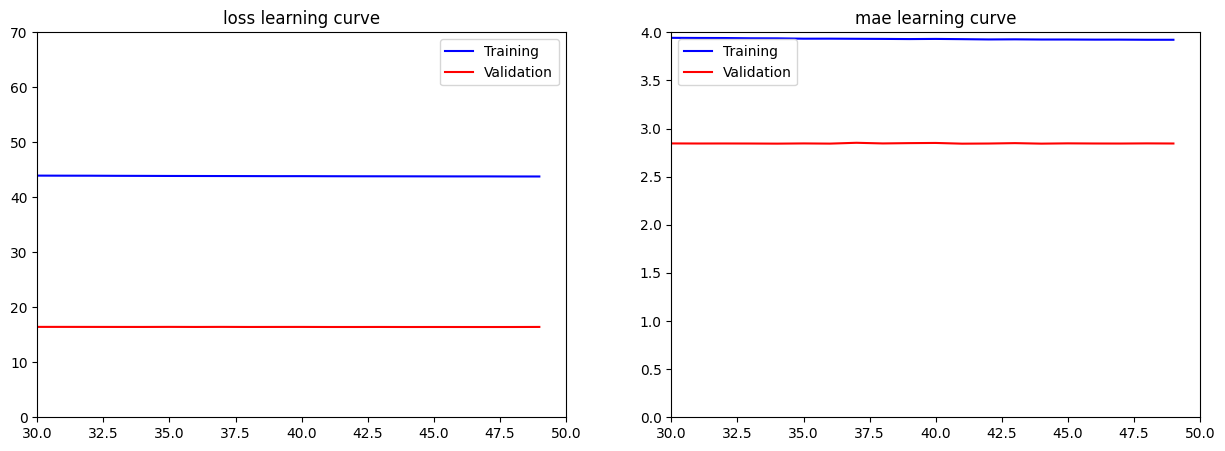

In [53]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch=30, metrics_max = [70, 4], val= True)

## LSTM

### Try 1

In [55]:
## Clears the current TensorFlow Keras session to free up resources and reset the state of the computational graph
tf.keras.backend.clear_session()


# Build the Model
model_lstm = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  LSTM(50),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range
])

model_lstm.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_lstm.fit(feature_label_train, epochs = 80, validation_data= feature_label_test )

Epoch 1/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 66.5994 - mae: 5.6180 - val_loss: 22.3274 - val_mae: 3.8989
Epoch 2/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 49.5939 - mae: 4.5894 - val_loss: 17.7935 - val_mae: 3.1267
Epoch 3/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 46.6754 - mae: 4.2575 - val_loss: 17.4766 - val_mae: 3.0758
Epoch 4/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 45.9570 - mae: 4.1734 - val_loss: 17.4437 - val_mae: 3.0777
Epoch 5/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 46.6354 - mae: 4.2070 - val_loss: 17.2505 - val_mae: 3.0348
Epoch 6/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 46.3775 - mae: 4.1776 - val_loss: 17.1350 - val_mae: 3.0097
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 44.3776 - mae: 4.0624 - val_loss: 16.9786 - val_mae: 2.9716
Epoch 8/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 44.8204 - mae: 4.0727 - val_loss: 16.9004 - val_mae: 2.9538
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/st

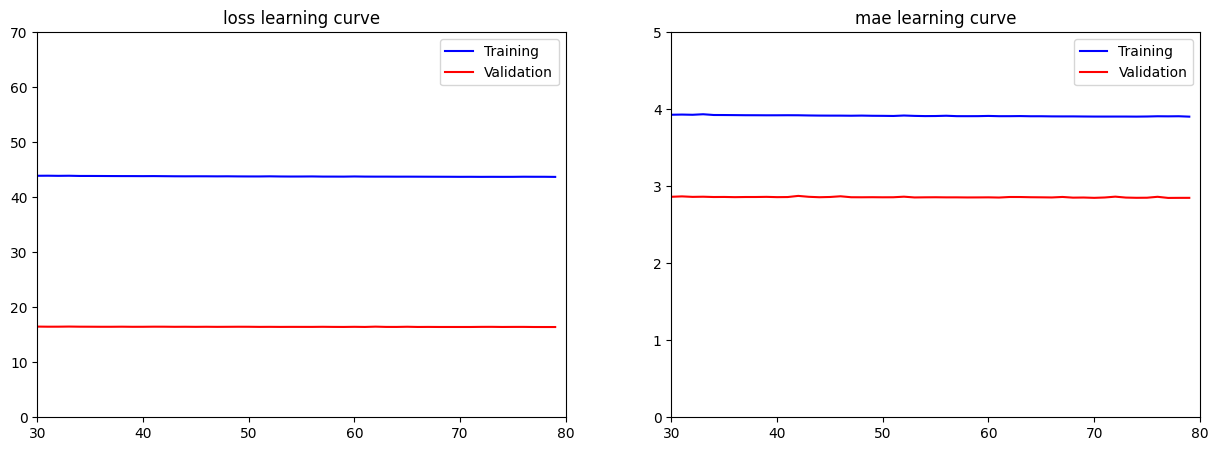

In [56]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch=30, metrics_max = [70, 5], val= True)

In [57]:
time_test, forecast_test_lstm = make_prediction(df_roi_4h, model = model_lstm, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True)

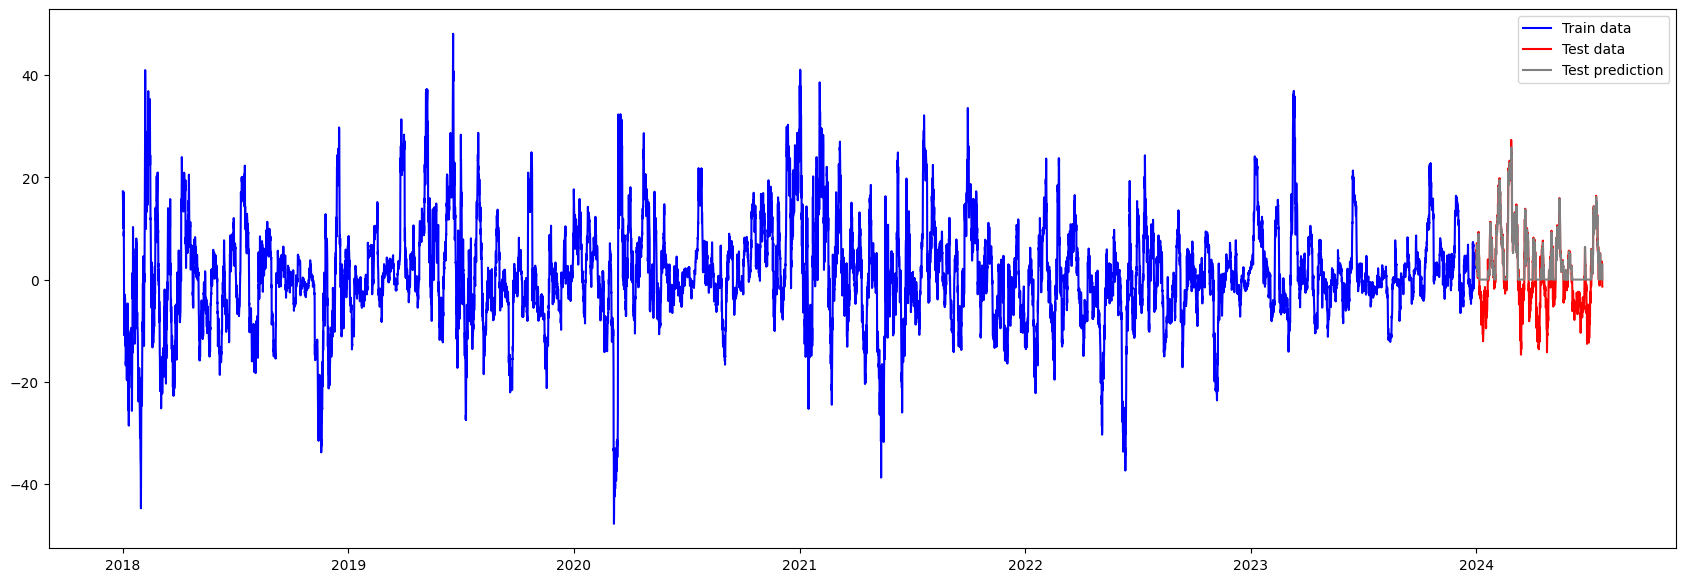

In [58]:
plt.figure(figsize = (21,7))
plt.plot(train, color = 'blue', label = "Train data")
#plt.plot(time_train, forecast_train_lstm, color = "gray", label = "Train prediction")
plt.plot(test, color = 'red', label = "Test data")
plt.plot(time_test, forecast_test_lstm, color = "gray", label = "Test prediction")

plt.legend()

## Bidirectional LSTM

In [59]:
## Clears the current TensorFlow Keras session to free up resources and reset the state of the computational graph
tf.keras.backend.clear_session()


# Build the Model
model_lstm = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size-1]), # Add an extra dimension to the input to make it compatible with the RNN layer
  Bidirectional(LSTM(50)),
  Dense(1, activation = 'relu'),
  Lambda(lambda x: x * 10)   # Scale the output by a factor of 10 to match the data range
])

model_lstm.compile(loss = "mse", metrics = ["mae"],optimizer = SGD(learning_rate=1e-5, momentum =0.9))

history = model_lstm.fit(feature_label_train, epochs = 80, validation_data= feature_label_test )

Epoch 1/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 63.6114 - mae: 5.4995 - val_loss: 21.5495 - val_mae: 3.7271
Epoch 2/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 51.2339 - mae: 4.6744 - val_loss: 18.5298 - val_mae: 3.2538
Epoch 3/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 47.4855 - mae: 4.3765 - val_loss: 17.8031 - val_mae: 3.1356
Epoch 4/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 45.4865 - mae: 4.2385 - val_loss: 17.4600 - val_mae: 3.0737
Epoch 5/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 46.1847 - mae: 4.2232 - val_loss: 17.2981 - val_mae: 3.0413
Epoch 6/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 45.6548 - mae: 4.2017 - val_loss: 17.1710 - val_mae: 3.0138
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 44.2760 - mae: 4.0839 - val_loss: 17.0694 - val_mae: 2.9941
Epoch 8/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 47.9010 - mae: 4.1925 - val_loss: 17.0001 - val_mae: 2.9825
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/st

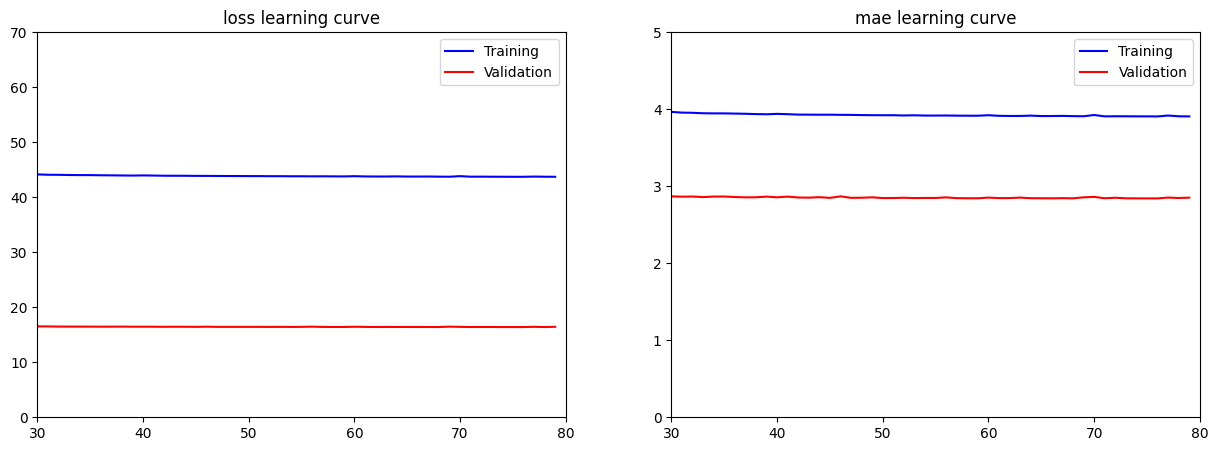

In [60]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch=30, metrics_max = [70, 5], val= True)

## CNN +LSTM

In [64]:
model = Sequential()
model.add(Conv1D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = [window_size-1, 1], kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None)))
model.add(LSTM(units =64, return_sequences = False, kernel_initializer=glorot_uniform(seed=None)))
model.add(Dense(1))
model.add(Lambda(lambda x: x*10))
model.compile(optimizer = SGD(learning_rate= 4e-5, momentum = .9), loss = "mse", metrics = ["mae"])
history = model.fit(feature_label_train, epochs = 30, validation_data=feature_label_test, verbose=1)


Epoch 1/30


c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     26/Unknown 2s 11ms/step - loss: 33.3045 - mae: 3.9500

c:\Users\solmaz\anaconda3\envs\TR\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 32.9728 - mae: 3.9288 - val_loss: 7.6979 - val_mae: 2.1473
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 11.3550 - mae: 2.2755 - val_loss: 4.2730 - val_mae: 1.5402
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.5483 - mae: 1.8613 - val_loss: 3.6430 - val_mae: 1.4372
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.5168 - mae: 1.7345 - val_loss: 3.3237 - val_mae: 1.3432
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.8657 - mae: 1.6399 - val_loss: 3.1955 - val_mae: 1.3118
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.5613 - mae: 1.5879 - val_loss: 3.1099 - val_mae: 1.2933
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4116 - mae: 1.5729 - val_loss: 3.1454 - val_mae: 1.2782
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3713 - mae: 1.5383 - val_loss: 2.9995 - val_mae: 1.2550
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.1551 - mae: 

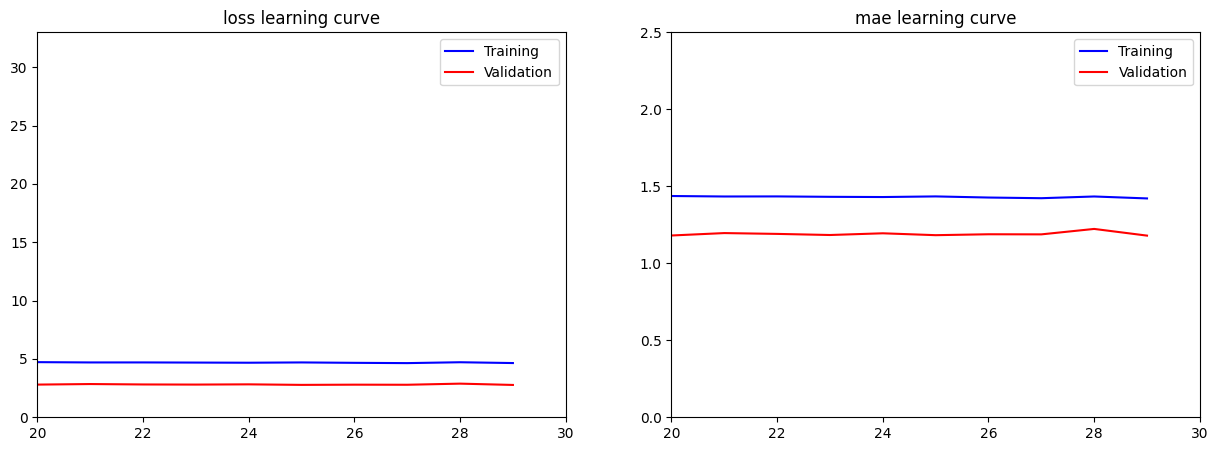

In [68]:
learning_curve(history, ['loss', 'mae'], zoom_in_epoch=20, metrics_max = [33, 2.5], val= True)

Like the 8 hours weekly ROI data, the CNN+LSTM model outperforms all previous models and could be a strong candidate for model inference. Note that, the forecaste step horizen for the next week ROI is 6*7 = 42.
